In [1]:
import sys
try:
    sys.getwindowsversion()
except AttributeError:
    isWindows = False
else:
    isWindows = True
if isWindows:
    import win32api,win32process,win32con
    pid = win32api.GetCurrentProcessId()
    handle = win32api.OpenProcess(win32con.PROCESS_ALL_ACCESS, True, pid)
    win32process.SetPriorityClass(handle, win32process.HIGH_PRIORITY_CLASS)
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, KFold, StratifiedKFold
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from datetime import datetime
from statsmodels.api import OLS
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import PolynomialFeatures
from geopy.geocoders import Nominatim
from nltk.corpus import stopwords
stop = stopwords.words('english')
from textblob import TextBlob
import itertools

### import the hotel performance data, remove symbolic encodings, split hotel names before "[" delimiter, replace dash and slashes with spaces, keep only alphanumeric, delete extra spaces, and trim the hotel names

In [2]:
hotelperformance = pd.read_csv('Denver Hotel Performance.csv',na_values=0, encoding='utf-8', engine = 'c')
hotelperformance['Name'] = hotelperformance['Name'].str.lower().str.replace(r'[^\x00-\x7F]+','', regex=True).str.split('[').str[0].str.replace('/', ' ').str.replace('-', ' ').str.replace('[^a-zA-Z0-9 ]', '').str.replace(r'\s+', ' ').apply(lambda x: x.strip())
hotelperformance

,Name,Response rate,Popularity,Room Score,Service Score,Food Score,Location Score,Overall Score
0,a bar d motel,0%,68%,NaN,50.0,NaN,100.0,63
1,ac hotel denver downtown,94%,90%,65.0,85.0,72.0,83.0,87
2,ahwahnee motel,0%,11%,47.0,50.0,NaN,NaN,75
3,airway motel,0%,57%,100.0,75.0,NaN,NaN,48
4,aloft denver downtown,97%,72%,61.0,92.0,61.0,91.0,83
...,...,...,...,...,...,...,...,...
327,white swan motel,0%,NaN,50.0,86.0,NaN,NaN,57
328,wingate by wyndham denver airport,5%,39%,74.0,81.0,50.0,94.0,88
329,wolfs motor inn,0%,0%,25.0,50.0,NaN,100.0,53
330,woodspring suites denver aurora,89%,69%,32.0,50.0,56.0,88.0,58


### replace space with underscores in the column names, convert the percentages to floats on the scale of 100, and replace the 0s with NaNs to impute later given that 0 is most likely a missing value than an actual score

In [3]:
hotelperformance.columns = hotelperformance.columns.str.replace(' ','_')
hotelperformance['Response_rate'] = hotelperformance['Response_rate'].str.rstrip('%').astype('float')
hotelperformance['Popularity'] = hotelperformance['Popularity'].str.rstrip('%').astype('float')
hotelperformance.replace(0, np.nan, inplace=True)
hotelperformance

,Name,Response_rate,Popularity,Room_Score,Service_Score,Food_Score,Location_Score,Overall_Score
0,a bar d motel,NaN,68.0,NaN,50.0,NaN,100.0,63
1,ac hotel denver downtown,94.0,90.0,65.0,85.0,72.0,83.0,87
2,ahwahnee motel,NaN,11.0,47.0,50.0,NaN,NaN,75
3,airway motel,NaN,57.0,100.0,75.0,NaN,NaN,48
4,aloft denver downtown,97.0,72.0,61.0,92.0,61.0,91.0,83
...,...,...,...,...,...,...,...,...
327,white swan motel,NaN,NaN,50.0,86.0,NaN,NaN,57
328,wingate by wyndham denver airport,5.0,39.0,74.0,81.0,50.0,94.0,88
329,wolfs motor inn,NaN,NaN,25.0,50.0,NaN,100.0,53
330,woodspring suites denver aurora,89.0,69.0,32.0,50.0,56.0,88.0,58


### this is the summary of missing values per column and the distributions

In [4]:
hotelperformance.isna().sum()

Name               0
Response_rate     54
Popularity        89
Room_Score         8
Service_Score      7
Food_Score        44
Location_Score    22
Overall_Score      0
dtype: int64

In [5]:
hotelperformance.describe()

,Response_rate,Popularity,Room_Score,Service_Score,Food_Score,Location_Score,Overall_Score
count,278.000000,243.000000,324.000000,325.000000,288.000000,310.000000,332.000000
mean,51.881295,58.078189,60.253086,78.787692,65.454861,86.267742,77.075301
std,29.655853,24.948171,18.065177,13.188139,19.274056,10.129386,11.899772
min,1.000000,3.000000,13.000000,25.000000,10.000000,50.000000,42.000000
25%,29.000000,40.000000,48.000000,73.000000,53.750000,81.000000,69.750000
50%,52.000000,59.000000,63.000000,80.000000,68.000000,87.500000,80.000000
75%,76.750000,79.000000,74.000000,88.000000,79.000000,94.000000,86.000000
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,99.000000


### The score distribution rate looks polynomial or slightly logrithmic

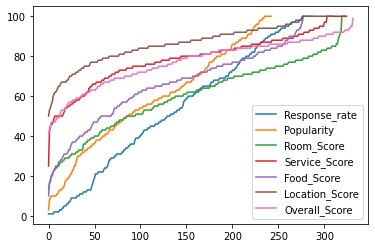

In [6]:
for values in hotelperformance.columns[hotelperformance.dtypes != "O"]:
    hotelperformance[values].sort_values().plot(use_index=False)
    plt.legend(loc="lower right")

### For imputation, make a copy of the dataset and only keep the full data set to make models of, in this case, 208 rows from the original 332 is kept to impute the missing columns

In [7]:
hotelperformance0 = hotelperformance.copy()
hotelperformance2 = hotelperformance.copy()
hotelperformance0.dropna(inplace=True)
hotelperformance0 = hotelperformance0.drop(columns='Name')
hotelperformance0 = hotelperformance0.reset_index(drop=True)
hotelperformance0

,Response_rate,Popularity,Room_Score,Service_Score,Food_Score,Location_Score,Overall_Score
0,94.0,90.0,65.0,85.0,72.0,83.0,87
1,97.0,72.0,61.0,92.0,61.0,91.0,83
2,7.0,58.0,55.0,76.0,56.0,88.0,79
3,46.0,10.0,24.0,60.0,37.0,56.0,55
4,61.0,56.0,59.0,87.0,38.0,94.0,80
...,...,...,...,...,...,...,...
204,61.0,43.0,45.0,67.0,72.0,85.0,71
205,52.0,30.0,79.0,78.0,100.0,54.0,70
206,84.0,80.0,61.0,74.0,65.0,79.0,75
207,5.0,39.0,74.0,81.0,50.0,94.0,88


### Given that there is an assumed relationship between overall score and the other scores, create a regression model to find the coefficients and intercept in which to fill the missing values from the target variable: Overall Score

In [8]:
y = hotelperformance0.pop('Overall_Score')

In [9]:
hotelperformance0

,Response_rate,Popularity,Room_Score,Service_Score,Food_Score,Location_Score
0,94.0,90.0,65.0,85.0,72.0,83.0
1,97.0,72.0,61.0,92.0,61.0,91.0
2,7.0,58.0,55.0,76.0,56.0,88.0
3,46.0,10.0,24.0,60.0,37.0,56.0
4,61.0,56.0,59.0,87.0,38.0,94.0
...,...,...,...,...,...,...
204,61.0,43.0,45.0,67.0,72.0,85.0
205,52.0,30.0,79.0,78.0,100.0,54.0
206,84.0,80.0,61.0,74.0,65.0,79.0
207,5.0,39.0,74.0,81.0,50.0,94.0


### Create regression metrics to evaluate models: variance, MSLE, R^2, MAE, MSE, RMSE

In [10]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

### Linear Regression has 0.84 r^2 with the following coefficients and intercept

In [11]:
model = LinearRegression(n_jobs=-1)
model.fit(hotelperformance0,y)
regression_results(y,model.predict(hotelperformance0))

explained_variance:  0.8466
mean_squared_log_error:  0.0029
r2:  0.8466
MAE:  2.8362
MSE:  15.3333
RMSE:  3.9158


In [12]:
model.coef_

array([-2.55040678e-04,  4.31975615e-02,  3.48372550e-01,  2.46934950e-01,
        3.24967360e-02,  9.66032149e-02])

In [13]:
model.intercept_

25.627812914798874

### Response rate has very little influence in predicting the Overall Score, with roomscore and service score being the most prominant features

In [14]:
features = pd.DataFrame(model.coef_,hotelperformance0.columns.values)
params = features.sort_values(0,ascending=False)
params

,0
Room_Score,0.348373
Service_Score,0.246935
Location_Score,0.096603
Popularity,0.043198
Food_Score,0.032497
Response_rate,-0.000255


### With the distribution rate of Overall Score looking like it's polynomial, 3rd degree polynomials are experiemented to figure out a better model to impute the missing variables

In [15]:
poly = PolynomialFeatures(degree = 3)
dfPoly = pd.DataFrame(
    data=poly.fit_transform(hotelperformance0), 
    columns=poly.get_feature_names(hotelperformance0.columns))
dfPoly

,1,Response_rate,Popularity,Room_Score,Service_Score,Food_Score,Location_Score,Response_rate^2,Response_rate Popularity,Response_rate Room_Score,...,Service_Score^3,Service_Score^2 Food_Score,Service_Score^2 Location_Score,Service_Score Food_Score^2,Service_Score Food_Score Location_Score,Service_Score Location_Score^2,Food_Score^3,Food_Score^2 Location_Score,Food_Score Location_Score^2,Location_Score^3
0,1.0,94.0,90.0,65.0,85.0,72.0,83.0,8836.0,8460.0,6110.0,...,614125.0,520200.0,599675.0,440640.0,507960.0,585565.0,373248.0,430272.0,496008.0,571787.0
1,1.0,97.0,72.0,61.0,92.0,61.0,91.0,9409.0,6984.0,5917.0,...,778688.0,516304.0,770224.0,342332.0,510692.0,761852.0,226981.0,338611.0,505141.0,753571.0
2,1.0,7.0,58.0,55.0,76.0,56.0,88.0,49.0,406.0,385.0,...,438976.0,323456.0,508288.0,238336.0,374528.0,588544.0,175616.0,275968.0,433664.0,681472.0
3,1.0,46.0,10.0,24.0,60.0,37.0,56.0,2116.0,460.0,1104.0,...,216000.0,133200.0,201600.0,82140.0,124320.0,188160.0,50653.0,76664.0,116032.0,175616.0
4,1.0,61.0,56.0,59.0,87.0,38.0,94.0,3721.0,3416.0,3599.0,...,658503.0,287622.0,711486.0,125628.0,310764.0,768732.0,54872.0,135736.0,335768.0,830584.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,1.0,61.0,43.0,45.0,67.0,72.0,85.0,3721.0,2623.0,2745.0,...,300763.0,323208.0,381565.0,347328.0,410040.0,484075.0,373248.0,440640.0,520200.0,614125.0
205,1.0,52.0,30.0,79.0,78.0,100.0,54.0,2704.0,1560.0,4108.0,...,474552.0,608400.0,328536.0,780000.0,421200.0,227448.0,1000000.0,540000.0,291600.0,157464.0
206,1.0,84.0,80.0,61.0,74.0,65.0,79.0,7056.0,6720.0,5124.0,...,405224.0,355940.0,432604.0,312650.0,379990.0,461834.0,274625.0,333775.0,405665.0,493039.0
207,1.0,5.0,39.0,74.0,81.0,50.0,94.0,25.0,195.0,370.0,...,531441.0,328050.0,616734.0,202500.0,380700.0,715716.0,125000.0,235000.0,441800.0,830584.0


### for simplicity's sake, no cross multiplying of variables are used in the imputation process, yet the model does get more accurate that way

In [16]:
dfPoly = dfPoly[dfPoly.columns.drop(list(dfPoly.filter(regex=' ')))]
dfPoly = dfPoly.drop(columns='1')
dfPoly

,Response_rate,Popularity,Room_Score,Service_Score,Food_Score,Location_Score,Response_rate^2,Popularity^2,Room_Score^2,Service_Score^2,Food_Score^2,Location_Score^2,Response_rate^3,Popularity^3,Room_Score^3,Service_Score^3,Food_Score^3,Location_Score^3
0,94.0,90.0,65.0,85.0,72.0,83.0,8836.0,8100.0,4225.0,7225.0,5184.0,6889.0,830584.0,729000.0,274625.0,614125.0,373248.0,571787.0
1,97.0,72.0,61.0,92.0,61.0,91.0,9409.0,5184.0,3721.0,8464.0,3721.0,8281.0,912673.0,373248.0,226981.0,778688.0,226981.0,753571.0
2,7.0,58.0,55.0,76.0,56.0,88.0,49.0,3364.0,3025.0,5776.0,3136.0,7744.0,343.0,195112.0,166375.0,438976.0,175616.0,681472.0
3,46.0,10.0,24.0,60.0,37.0,56.0,2116.0,100.0,576.0,3600.0,1369.0,3136.0,97336.0,1000.0,13824.0,216000.0,50653.0,175616.0
4,61.0,56.0,59.0,87.0,38.0,94.0,3721.0,3136.0,3481.0,7569.0,1444.0,8836.0,226981.0,175616.0,205379.0,658503.0,54872.0,830584.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,61.0,43.0,45.0,67.0,72.0,85.0,3721.0,1849.0,2025.0,4489.0,5184.0,7225.0,226981.0,79507.0,91125.0,300763.0,373248.0,614125.0
205,52.0,30.0,79.0,78.0,100.0,54.0,2704.0,900.0,6241.0,6084.0,10000.0,2916.0,140608.0,27000.0,493039.0,474552.0,1000000.0,157464.0
206,84.0,80.0,61.0,74.0,65.0,79.0,7056.0,6400.0,3721.0,5476.0,4225.0,6241.0,592704.0,512000.0,226981.0,405224.0,274625.0,493039.0
207,5.0,39.0,74.0,81.0,50.0,94.0,25.0,1521.0,5476.0,6561.0,2500.0,8836.0,125.0,59319.0,405224.0,531441.0,125000.0,830584.0


### the r^2 for the polynomial fit is 0.87, slightly better than the linear fit

In [17]:
poly.fit(dfPoly, y)
lin2 = LinearRegression()
lin2.fit(dfPoly, y)
regression_results(y,lin2.predict(dfPoly))

explained_variance:  0.8702
mean_squared_log_error:  0.0024
r2:  0.8702
MAE:  2.6801
MSE:  12.9755
RMSE:  3.6022


### Here are the coefficients and intercept in which to solve the imputed missing variables

In [18]:
features = pd.DataFrame(lin2.coef_,dfPoly.columns.values)
params2 = features.sort_values(0,ascending=False)
params2

,0
Service_Score,2.643026
Room_Score,1.323265
Popularity,0.072575
Response_rate,0.033740
Location_Score^2,0.017989
Food_Score^2,0.014040
Popularity^2,0.000553
Service_Score^3,0.000159
Room_Score^3,0.000078
Response_rate^3,0.000012


In [19]:
lin2.intercept_

-14.060489539784143

### 209 rows have no missing variables, 70 rows has 1 missing variables...all the way to 5 rows have 5 missing variables

In [20]:
pd.DataFrame(hotelperformance.isnull().sum(axis=1)).reset_index().groupby(0).count()

,index
0,
0,209
1,70
2,23
3,17
4,8
5,5


### only the rows with 1 missing variable is isolated to generate numbers with given the polynomial's model and coefficients

In [21]:
hotelperformance1na = hotelperformance.loc[hotelperformance.isnull().sum(axis=1) == 1]
hotelperformance1na

,Name,Response_rate,Popularity,Room_Score,Service_Score,Food_Score,Location_Score,Overall_Score
11,aurora inn,67.0,100.0,71.0,93.0,NaN,100.0,84
16,baymont inn and suites denver west federal center,40.0,NaN,32.0,55.0,40.0,77.0,60
17,belcaro motel,53.0,31.0,70.0,75.0,NaN,94.0,80
20,best western hotel westminster,96.0,NaN,60.0,89.0,94.0,83.0,80
23,best western stapleton hotel denver,NaN,47.0,28.0,56.0,43.0,72.0,42
...,...,...,...,...,...,...,...,...
292,the boston inn westminster,82.0,NaN,58.0,82.0,64.0,97.0,70
297,the golden hotel an ascend collection hotel,69.0,NaN,81.0,97.0,94.0,97.0,92
313,towneplace suites tacoma lakewood,65.0,NaN,72.0,89.0,58.0,100.0,87
323,western motel,12.0,50.0,60.0,100.0,NaN,100.0,62


### These are the missing tally per column

In [22]:
missing = pd.DataFrame(hotelperformance1na.isna().sum()).reset_index() 
missing = missing[missing[0]>0]
missing

,index,0
1,Response_rate,6
2,Popularity,57
5,Food_Score,7


### some scrap work for a double for loop in order to impute the data from model coefficients and intercept

In [23]:
paramsdict = params.to_dict()[0]
paramsdict

{'Room_Score': 0.3483725500078106,
 'Service_Score': 0.24693495005004024,
 'Location_Score': 0.09660321487620267,
 'Popularity': 0.04319756152952987,
 'Food_Score': 0.032496736028080814,
 'Response_rate': -0.00025504067773092384}

In [24]:
paramsdict2 = params2.to_dict()[0]
paramsdict2

{'Service_Score': 2.6430259239726484,
 'Room_Score': 1.3232653022987897,
 'Popularity': 0.07257544285190867,
 'Response_rate': 0.03373996274594299,
 'Location_Score^2': 0.017989429691397628,
 'Food_Score^2': 0.014040305204523835,
 'Popularity^2': 0.0005529698081223088,
 'Service_Score^3': 0.00015891290361785671,
 'Room_Score^3': 7.773190123061706e-05,
 'Response_rate^3': 1.209106427781964e-05,
 'Popularity^3': -8.691461369799922e-06,
 'Food_Score^3': -7.8426440642209e-05,
 'Location_Score^3': -9.246486133321143e-05,
 'Response_rate^2': -0.0014893510777439641,
 'Room_Score^2': -0.015525816373620108,
 'Service_Score^2': -0.03440403193321048,
 'Food_Score': -0.7481246153351727,
 'Location_Score': -0.9965280972636542}

In [25]:
del paramsdict['Popularity']
paramsdict

{'Room_Score': 0.3483725500078106,
 'Service_Score': 0.24693495005004024,
 'Location_Score': 0.09660321487620267,
 'Food_Score': 0.032496736028080814,
 'Response_rate': -0.00025504067773092384}

In [26]:
scores = params[0].keys().tolist()
scores

['Room_Score',
 'Service_Score',
 'Location_Score',
 'Popularity',
 'Food_Score',
 'Response_rate']

In [27]:
scores.remove('Popularity')
scores

['Room_Score',
 'Service_Score',
 'Location_Score',
 'Food_Score',
 'Response_rate']

In [28]:
coef = params[0].values.tolist()
coef

[0.3483725500078106,
 0.24693495005004024,
 0.09660321487620267,
 0.04319756152952987,
 0.032496736028080814,
 -0.00025504067773092384]

In [29]:
for score,val in zip(paramsdict,paramsdict.values()):
    print(score,val)

Room_Score 0.3483725500078106
Service_Score 0.24693495005004024
Location_Score 0.09660321487620267
Food_Score 0.032496736028080814
Response_rate -0.00025504067773092384


### this is the linear model method in which missing values would be imputed

In [30]:
# for key in params[0].keys().tolist():
#     sub = hotelperformance1na[hotelperformance1na[key].isna()==True]
#     paramsdict = params.to_dict()[0]
#     mult = paramsdict[key]
#     del paramsdict[key]
#     templist = sub['Overall_Score'] - model.intercept_
#     for score,val in zip(paramsdict,paramsdict.values()):
#         templist -= sub[score]*val
#     hotelperformance[key].iloc[sub.index] = templist / mult

# hotelperformance

In [31]:
paramsdict2

{'Service_Score': 2.6430259239726484,
 'Room_Score': 1.3232653022987897,
 'Popularity': 0.07257544285190867,
 'Response_rate': 0.03373996274594299,
 'Location_Score^2': 0.017989429691397628,
 'Food_Score^2': 0.014040305204523835,
 'Popularity^2': 0.0005529698081223088,
 'Service_Score^3': 0.00015891290361785671,
 'Room_Score^3': 7.773190123061706e-05,
 'Response_rate^3': 1.209106427781964e-05,
 'Popularity^3': -8.691461369799922e-06,
 'Food_Score^3': -7.8426440642209e-05,
 'Location_Score^3': -9.246486133321143e-05,
 'Response_rate^2': -0.0014893510777439641,
 'Room_Score^2': -0.015525816373620108,
 'Service_Score^2': -0.03440403193321048,
 'Food_Score': -0.7481246153351727,
 'Location_Score': -0.9965280972636542}

In [32]:
score

'Response_rate'

In [33]:
val

-0.00025504067773092384

In [34]:
missing['index']

1    Response_rate
2       Popularity
5       Food_Score
Name: index, dtype: object

In [35]:
hotelperformance

,Name,Response_rate,Popularity,Room_Score,Service_Score,Food_Score,Location_Score,Overall_Score
0,a bar d motel,NaN,68.0,NaN,50.0,NaN,100.0,63
1,ac hotel denver downtown,94.0,90.0,65.0,85.0,72.0,83.0,87
2,ahwahnee motel,NaN,11.0,47.0,50.0,NaN,NaN,75
3,airway motel,NaN,57.0,100.0,75.0,NaN,NaN,48
4,aloft denver downtown,97.0,72.0,61.0,92.0,61.0,91.0,83
...,...,...,...,...,...,...,...,...
327,white swan motel,NaN,NaN,50.0,86.0,NaN,NaN,57
328,wingate by wyndham denver airport,5.0,39.0,74.0,81.0,50.0,94.0,88
329,wolfs motor inn,NaN,NaN,25.0,50.0,NaN,100.0,53
330,woodspring suites denver aurora,89.0,69.0,32.0,50.0,56.0,88.0,58


### This is the polynomial way in which numbers are generated to figure out the real numbers that would fit the imputation model for the coefficients

In [36]:
for key in missing['index'].values:
    sub = hotelperformance1na[hotelperformance1na[key].isna()==True]
    paramsdict2 = params2.to_dict()[0]
    mult = paramsdict2[key]
    a,b,c = paramsdict2[key],paramsdict2[key+'^2'],paramsdict2[key+'^3']
    del paramsdict2[key],paramsdict2[key+'^2'],paramsdict2[key+'^3']
    templist = sub['Overall_Score'] - lin2.intercept_
    for score,val in zip(paramsdict2,paramsdict2.values()):
        if score[-2:-1] == '^':
            templist -= sub[score[:-2]]**int(score[-1:])*val
        else:
            templist -= sub[score]*val
    hotelperformance[key].iloc[sub.index] = pd.DataFrame(templist).applymap(lambda x: np.roots([a,b,c,-x])[~np.iscomplex(np.roots([a,b,c,-x]))].astype(np.float64))['Overall_Score'].str[0]

hotelperformance

,Name,Response_rate,Popularity,Room_Score,Service_Score,Food_Score,Location_Score,Overall_Score
0,a bar d motel,NaN,68.000000,NaN,50.0,NaN,100.0,63
1,ac hotel denver downtown,94.0,90.000000,65.0,85.0,72.0,83.0,87
2,ahwahnee motel,NaN,11.000000,47.0,50.0,NaN,NaN,75
3,airway motel,NaN,57.000000,100.0,75.0,NaN,NaN,48
4,aloft denver downtown,97.0,72.000000,61.0,92.0,61.0,91.0,83
...,...,...,...,...,...,...,...,...
327,white swan motel,NaN,NaN,50.0,86.0,NaN,NaN,57
328,wingate by wyndham denver airport,5.0,39.000000,74.0,81.0,50.0,94.0,88
329,wolfs motor inn,NaN,NaN,25.0,50.0,NaN,100.0,53
330,woodspring suites denver aurora,89.0,69.000000,32.0,50.0,56.0,88.0,58


### The rows with 1 missing value are filled with imputed numbers

In [37]:
pd.DataFrame(hotelperformance.isnull().sum(axis=1)).reset_index().groupby(0).count()

,index
0,
0,279
2,23
3,17
4,8
5,5


### There is an increase from 209 to 279 rows once the missing values are imputed

In [38]:
hotelperformance.dropna(inplace=True)
hotelperformance

,Name,Response_rate,Popularity,Room_Score,Service_Score,Food_Score,Location_Score,Overall_Score
1,ac hotel denver downtown,94.0,90.000000,65.0,85.0,72.000000,83.0,87
4,aloft denver downtown,97.0,72.000000,61.0,92.0,61.000000,91.0,83
5,aloft denver international airport,7.0,58.000000,55.0,76.0,56.000000,88.0,79
6,americas best value inn lakewood south tacoma,46.0,10.000000,24.0,60.0,37.000000,56.0,55
7,americas best value inn westminster huntington...,61.0,56.000000,59.0,87.0,38.000000,94.0,80
...,...,...,...,...,...,...,...,...
321,warwick denver hotel,84.0,80.000000,61.0,74.0,65.000000,79.0,75
323,western motel,12.0,50.000000,60.0,100.0,3.620501,100.0,62
328,wingate by wyndham denver airport,5.0,39.000000,74.0,81.0,50.000000,94.0,88
330,woodspring suites denver aurora,89.0,69.000000,32.0,50.0,56.000000,88.0,58


### There is a library from scikit learn to impute numbers based on the naive bayes pattern of the numbers to fill in those missing numbers based on the pattern of the dataset for all 332 rows to be imputed with numbers to salvage the rest of the missing dataset

In [39]:
imp = IterativeImputer(max_iter=10, random_state=0)
hotelperformanceNum = hotelperformance2.drop(columns='Name')
imp.fit(hotelperformanceNum)
IterativeImputer(random_state=0)
hotelperformanceimputed = pd.DataFrame(imp.transform(hotelperformanceNum), columns=hotelperformanceNum.columns.values)
hotelperformanceimputed['Hotel Name'] = hotelperformance2['Name']
hotelperformanceimputed

,Response_rate,Popularity,Room_Score,Service_Score,Food_Score,Location_Score,Overall_Score,Hotel Name
0,50.163248,68.000000,43.458295,50.0,45.830969,100.000000,63.0,a bar d motel
1,94.000000,90.000000,65.000000,85.0,72.000000,83.000000,87.0,ac hotel denver downtown
2,48.550958,11.000000,47.000000,50.0,48.546167,74.528917,75.0,ahwahnee motel
3,52.266580,57.000000,100.000000,75.0,70.961361,88.401158,48.0,airway motel
4,97.000000,72.000000,61.000000,92.0,61.000000,91.000000,83.0,aloft denver downtown
...,...,...,...,...,...,...,...,...
327,50.757905,46.279611,50.000000,86.0,60.022100,87.981514,57.0,white swan motel
328,5.000000,39.000000,74.000000,81.0,50.000000,94.000000,88.0,wingate by wyndham denver airport
329,48.197342,36.275292,25.000000,50.0,37.278339,100.000000,53.0,wolfs motor inn
330,89.000000,69.000000,32.000000,50.0,56.000000,88.000000,58.0,woodspring suites denver aurora


In [40]:
# hotelperformanceimputed.to_csv('asdf.csv',index=False)

### As a precaution the imputed dataset could be labeled with 0s or 1s signifying if the data is original or imputed for the model to pick up on the difference when making futher predictions on the model, merged later

In [41]:
imputed = pd.DataFrame(np.where(hotelperformance2[hotelperformance.columns[1:-1]].notnull(), '0', '1'),columns=hotelperformance2.columns.values[1:-1]).add_prefix('imp_')
imputed

,imp_Response_rate,imp_Popularity,imp_Room_Score,imp_Service_Score,imp_Food_Score,imp_Location_Score
0,1,0,1,0,1,0
1,0,0,0,0,0,0
2,1,0,0,0,1,1
3,1,0,0,0,1,1
4,0,0,0,0,0,0
...,...,...,...,...,...,...
327,1,1,0,0,1,1
328,0,0,0,0,0,0
329,1,1,0,0,1,0
330,0,0,0,0,0,0


### the imputed values have decimals while the nonimputed values are whole numbers

In [42]:
hotelperformancefull = hotelperformanceimputed
# hotelperformancefull = pd.concat([hotelperformanceimputed, imputed], axis=1)
hotelperformancefull

,Response_rate,Popularity,Room_Score,Service_Score,Food_Score,Location_Score,Overall_Score,Hotel Name
0,50.163248,68.000000,43.458295,50.0,45.830969,100.000000,63.0,a bar d motel
1,94.000000,90.000000,65.000000,85.0,72.000000,83.000000,87.0,ac hotel denver downtown
2,48.550958,11.000000,47.000000,50.0,48.546167,74.528917,75.0,ahwahnee motel
3,52.266580,57.000000,100.000000,75.0,70.961361,88.401158,48.0,airway motel
4,97.000000,72.000000,61.000000,92.0,61.000000,91.000000,83.0,aloft denver downtown
...,...,...,...,...,...,...,...,...
327,50.757905,46.279611,50.000000,86.0,60.022100,87.981514,57.0,white swan motel
328,5.000000,39.000000,74.000000,81.0,50.000000,94.000000,88.0,wingate by wyndham denver airport
329,48.197342,36.275292,25.000000,50.0,37.278339,100.000000,53.0,wolfs motor inn
330,89.000000,69.000000,32.000000,50.0,56.000000,88.000000,58.0,woodspring suites denver aurora


### import the hotel info data, remove symbolic encodings, split hotel names before "[" delimiter, replace dash and slashes with spaces, keep only alphanumeric, delete extra spaces, and trim the hotel names. State and Country is removed because the data is all in Colorado, US

In [43]:
hotelinfo = pd.read_csv('Denver Hotel Info.csv',encoding='utf-8', engine = 'c').drop(columns=['State','Country'])
hotelinfo['Hotel Name'] = hotelinfo['Hotel Name'].str.lower().str.replace(r'[^\x00-\x7F]+','', regex=True).str.split('[').str[0].str.replace('/', ' ').str.replace('-', ' ').str.replace('[^a-zA-Z0-9 ]', '').str.replace(r'\s+', ' ').apply(lambda x: x.strip())
hotelinfo

,Hotel Name,Brand Name,City,Class Type,Location Type,Price Type,Restaurant (Y/N),Conference (Y/N),Spa (Y/N),Total Rooms,Floor Count,Rate
0,11th avenue hotel hostel,Independent,Denver,Economy Class,Urban,Budget,N,N,N,100,3,$40
1,a d motel,Independent,Lakewood,Economy Class,Suburban,Budget,N,N,N,12,1,$33
2,ac hotels by marriott denver downtown,AC Hotels by Marriott,Denver,Upscale Class,Urban,Luxury,Y,N,N,223,19,$226
3,affordable inn wheat ridge,Independent,Wheat Ridge,Economy Class,Suburban,Budget,N,N,N,100,2,$40
4,all inn motel,Independent,Denver,Economy Class,Urban,Budget,N,N,N,54,4,$27
...,...,...,...,...,...,...,...,...,...,...,...,...
375,woodspring suites denver aurora,WoodSpring Suites,Aurora,Economy Class,Suburban,Budget,N,N,N,121,4,$22
376,woodspring suites denver centennial,WoodSpring Suites,Centennial,Economy Class,Suburban,Budget,N,N,N,122,4,$24
377,woolleys classic suites denver international a...,Independent,Aurora,Upper Upscale Class,Suburban,Upscale,Y,N,N,189,4,$66
378,wright motel,Independent,Englewood,Economy Class,Suburban,Budget,N,N,N,34,2,$57


### The hotel info dataset is more complete with no missing values

In [44]:
pd.DataFrame(hotelinfo.isna().sum()).reset_index()

,index,0
0,Hotel Name,0
1,Brand Name,0
2,City,0
3,Class Type,0
4,Location Type,0
5,Price Type,0
6,Restaurant (Y/N),0
7,Conference (Y/N),0
8,Spa (Y/N),0
9,Total Rooms,0


### The Yes/No answers are converted into 0s and 1s, the dollar rate is converted into numeric

In [45]:
hotelinfo[['Restaurant (Y/N)','Conference (Y/N)','Spa (Y/N)']] = hotelinfo[['Restaurant (Y/N)','Conference (Y/N)','Spa (Y/N)']].eq('Y').mul(1)
hotelinfo['Rate'] = hotelinfo['Rate'].str.replace('$', '').str.replace(',', '').astype(int)
hotelinfo

,Hotel Name,Brand Name,City,Class Type,Location Type,Price Type,Restaurant (Y/N),Conference (Y/N),Spa (Y/N),Total Rooms,Floor Count,Rate
0,11th avenue hotel hostel,Independent,Denver,Economy Class,Urban,Budget,0,0,0,100,3,40
1,a d motel,Independent,Lakewood,Economy Class,Suburban,Budget,0,0,0,12,1,33
2,ac hotels by marriott denver downtown,AC Hotels by Marriott,Denver,Upscale Class,Urban,Luxury,1,0,0,223,19,226
3,affordable inn wheat ridge,Independent,Wheat Ridge,Economy Class,Suburban,Budget,0,0,0,100,2,40
4,all inn motel,Independent,Denver,Economy Class,Urban,Budget,0,0,0,54,4,27
...,...,...,...,...,...,...,...,...,...,...,...,...
375,woodspring suites denver aurora,WoodSpring Suites,Aurora,Economy Class,Suburban,Budget,0,0,0,121,4,22
376,woodspring suites denver centennial,WoodSpring Suites,Centennial,Economy Class,Suburban,Budget,0,0,0,122,4,24
377,woolleys classic suites denver international a...,Independent,Aurora,Upper Upscale Class,Suburban,Upscale,1,0,0,189,4,66
378,wright motel,Independent,Englewood,Economy Class,Suburban,Budget,0,0,0,34,2,57


### For the purposes of this, more stop words are added to see if the hotel names could be merged once the hotel names are simplified removing stopwords such as cardinal directions, brand names, location, and what type of hotel it is

In [46]:
stop = [i for i in stop if len(i) > 1]
stop.extend(['denver','colorado','marriott','inn','hotel','motel','motor','hilton','bar','nw','sw','se','ne','north','east','south','west','northwest','northeast','southeast','southwest'])

### Possessive in names are lemmatized to reduce the complexity of the words, stop words are removed, extra spaces are removed and trimmed. Spell checker was an option but given that most of these names include city names, those could not be spell checked with a basic dictionary

In [47]:
pat = r'\b(:{})\b'.format('|'.join(stop))
hotelperformancefull['Hotel Name2'] = hotelperformancefull['Hotel Name'].str.replace(r'(\w{2,})s\b', r'\1').str.replace(pat, '').str.replace(r'\s+', ' ').apply(lambda x: x.strip())
# hotelperformancefull['Hotel Name2'] = hotelperformancefull['Hotel Name2'].apply(lambda txt: ''.join(TextBlob(txt).correct()))

hotelinfo['Hotel Name2'] = hotelinfo['Hotel Name'].str.replace(r'(\w{2,})s\b', r'\1').str.replace(pat, '').str.replace(r'\s+', ' ').apply(lambda x: x.strip())
# hotelinfo['Hotel Name2'] = hotelinfo['Hotel Name2'].apply(lambda txt: ''.join(TextBlob(txt).correct()))

### The result of the outer merge created 547 rows

In [48]:
result = pd.merge(hotelperformancefull, hotelinfo, how="outer", on="Hotel Name2")
result

,Response_rate,Popularity,Room_Score,Service_Score,Food_Score,Location_Score,Overall_Score,Hotel Name_x,Hotel Name2,Hotel Name_y,...,City,Class Type,Location Type,Price Type,Restaurant (Y/N),Conference (Y/N),Spa (Y/N),Total Rooms,Floor Count,Rate
0,50.163248,68.0,43.458295,50.0,45.830969,100.000000,63.0,a bar d motel,a d,a d motel,...,Lakewood,Economy Class,Suburban,Budget,0.0,0.0,0.0,12.0,1.0,33.0
1,94.000000,90.0,65.000000,85.0,72.000000,83.000000,87.0,ac hotel denver downtown,ac downtown,ac hotels by marriott denver downtown,...,Denver,Upscale Class,Urban,Luxury,1.0,0.0,0.0,223.0,19.0,226.0
2,48.550958,11.0,47.000000,50.0,48.546167,74.528917,75.0,ahwahnee motel,ahwahnee,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,52.266580,57.0,100.000000,75.0,70.961361,88.401158,48.0,airway motel,airway,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,97.000000,72.0,61.000000,92.0,61.000000,91.000000,83.0,aloft denver downtown,aloft downtown,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,woodspring suite aurora airport,woodspring suites aurora denver airport,...,Aurora,Economy Class,Suburban,Budget,0.0,0.0,0.0,122.0,4.0,22.0
544,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,woodspring suite centennial,woodspring suites denver centennial,...,Centennial,Economy Class,Suburban,Budget,0.0,0.0,0.0,122.0,4.0,24.0
545,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,woolley classic suite international airport,woolleys classic suites denver international a...,...,Aurora,Upper Upscale Class,Suburban,Upscale,1.0,0.0,0.0,189.0,4.0,66.0
546,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,wright,wright motel,...,Englewood,Economy Class,Suburban,Budget,0.0,0.0,0.0,34.0,2.0,57.0


In [49]:
result['Hotel Name2'] = result['Hotel Name2'].replace(r'^\s*$', np.nan, regex=True)

### of the 548 rows, 177 rows were matched with 371 rows as imperfect matches

In [50]:
pd.DataFrame(result.isnull().sum(axis=1)).reset_index().groupby(0).count()

,index
0,
0,177
1,3
8,208
12,160


### There is such thing as a fuzzy merge, but given how similar hotel names are with one location difference, the fuzzy match would have created surplus merge rows and was not ultimately used in this exercise

In [51]:
result['nonmatching'] = pd.DataFrame(result.isnull().sum(axis=1))
unmatched = result[result['nonmatching']>0].sort_values('Hotel Name2')
unmatched

,Response_rate,Popularity,Room_Score,Service_Score,Food_Score,Location_Score,Overall_Score,Hotel Name_x,Hotel Name2,Hotel Name_y,...,Class Type,Location Type,Price Type,Restaurant (Y/N),Conference (Y/N),Spa (Y/N),Total Rooms,Floor Count,Rate,nonmatching
340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11th avenue hostel,11th avenue hotel hostel,...,Economy Class,Urban,Budget,0.0,0.0,0.0,100.0,3.0,40.0,8
214,10.0,47.358071,27.0,100.0,100.0,100.0,63.0,motel 6 chicago southwest aurora,6 chicago aurora,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6 tech center,motel 6 denver south south tech center,...,Economy Class,Suburban,Budget,0.0,0.0,0.0,129.0,5.0,56.0,8
480,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6 thornton,motel 6 denver thornton,...,Economy Class,Suburban,Budget,0.0,0.0,0.0,120.0,2.0,56.0,8
218,25.0,58.300152,50.0,90.0,61.0,91.0,80.0,motel 6 westminster north,6 westminster,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
546,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,wright,wright motel,...,Economy Class,Suburban,Budget,0.0,0.0,0.0,34.0,2.0,57.0,8
547,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,wyndham origin red rock,wyndham origin hotel red rocks,...,Upscale Class,Suburban,Upscale,1.0,0.0,0.0,124.0,4.0,209.0,8
205,65.0,67.000000,58.0,83.0,65.0,92.0,83.0,marriott denver west,NaN,all inn motel,...,Economy Class,Urban,Budget,0.0,0.0,0.0,54.0,4.0,27.0,1
206,65.0,67.000000,58.0,83.0,65.0,92.0,83.0,marriott denver west,NaN,denver west inn,...,Economy Class,Suburban,Budget,1.0,0.0,0.0,122.0,2.0,53.0,1


### Here are the 177 rows that are matched after distilling the hotel names to its root words as the column 'hotel name2'

In [52]:
matched = result[result['nonmatching']==0].sort_values('Hotel Name2')
matched

,Response_rate,Popularity,Room_Score,Service_Score,Food_Score,Location_Score,Overall_Score,Hotel Name_x,Hotel Name2,Hotel Name_y,...,Class Type,Location Type,Price Type,Restaurant (Y/N),Conference (Y/N),Spa (Y/N),Total Rooms,Floor Count,Rate,nonmatching
216,34.000000,14.000000,43.000000,85.0,31.000000,79.000000,67.0,motel 6 denver airport,6 airport,motel 6 denver airport,...,Economy Class,Airport,Budget,0.0,0.0,0.0,139.0,2.0,59.0,0
213,24.000000,54.136465,51.000000,88.0,28.000000,85.000000,77.0,motel 6 aurora,6 aurora,motel 6 aurora east,...,Economy Class,Suburban,Budget,0.0,0.0,0.0,122.0,3.0,59.0,0
217,33.000000,12.000000,36.000000,74.0,42.000000,78.000000,69.0,motel 6 denver central federal boulevard,6 central federal boulevard,motel 6 denver central federal boulevard,...,Economy Class,Suburban,Budget,0.0,0.0,0.0,191.0,3.0,59.0,0
215,22.000000,41.463683,47.000000,60.0,31.000000,73.000000,65.0,motel 6 denver lakewood,6 lakewood,motel 6 denver lakewood,...,Economy Class,Suburban,Budget,0.0,0.0,0.0,120.0,2.0,53.0,0
0,50.163248,68.000000,43.458295,50.0,45.830969,100.000000,63.0,a bar d motel,a d,a d motel,...,Economy Class,Suburban,Budget,0.0,0.0,0.0,12.0,1.0,33.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,54.046596,69.646150,85.000000,100.0,100.000000,93.802848,74.0,westminster motor inn,westminster,marriott denver westminster,...,Upper Upscale Class,Suburban,Upscale,1.0,0.0,0.0,215.0,6.0,296.0,0
335,50.757905,46.279611,50.000000,86.0,60.022100,87.981514,57.0,white swan motel,white swan,white swan motel,...,Economy Class,Suburban,Budget,1.0,0.0,0.0,20.0,1.0,32.0,0
336,5.000000,39.000000,74.000000,81.0,50.000000,94.000000,88.0,wingate by wyndham denver airport,wingate wyndham airport,wingate by wyndham denver airport,...,Midscale Class,Airport,Economy,0.0,0.0,0.0,123.0,4.0,119.0,0
337,48.197342,36.275292,25.000000,50.0,37.278339,100.000000,53.0,wolfs motor inn,wolf,wolfs motor inn,...,Economy Class,Suburban,Budget,0.0,0.0,0.0,33.0,2.0,33.0,0


In [53]:
# unmatched.to_csv('asdf2.csv',index=False,encoding='utf-8')

### of the unmatched columns, they are separated to an unmatched subset of hotel info and hotel performance to be merged again later

In [54]:
unmatched.columns.values[8:]

array(['Hotel Name2', 'Hotel Name_y', 'Brand Name', 'City', 'Class Type',
       'Location Type', 'Price Type', 'Restaurant (Y/N)',
       'Conference (Y/N)', 'Spa (Y/N)', 'Total Rooms', 'Floor Count',
       'Rate', 'nonmatching'], dtype=object)

In [55]:
hotelinfounmatched = unmatched[unmatched.columns.values[8:]][(unmatched['nonmatching']==8)|(unmatched['nonmatching']==1)]
hotelinfounmatched

,Hotel Name2,Hotel Name_y,Brand Name,City,Class Type,Location Type,Price Type,Restaurant (Y/N),Conference (Y/N),Spa (Y/N),Total Rooms,Floor Count,Rate,nonmatching
340,11th avenue hostel,11th avenue hotel hostel,Independent,Denver,Economy Class,Urban,Budget,0.0,0.0,0.0,100.0,3.0,40.0,8
481,6 tech center,motel 6 denver south south tech center,Motel 6,Greenwood Village,Economy Class,Suburban,Budget,0.0,0.0,0.0,129.0,5.0,56.0,8
480,6 thornton,motel 6 denver thornton,Motel 6,Thornton,Economy Class,Suburban,Budget,0.0,0.0,0.0,120.0,2.0,56.0,8
482,6 wheat ridge,motel 6 denver west wheat ridge north,Motel 6,Wheat Ridge,Economy Class,Suburban,Budget,0.0,0.0,0.0,94.0,2.0,59.0,8
341,affordable wheat ridge,affordable inn wheat ridge,Independent,Wheat Ridge,Economy Class,Suburban,Budget,0.0,0.0,0.0,100.0,2.0,40.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
546,wright,wright motel,Independent,Englewood,Economy Class,Suburban,Budget,0.0,0.0,0.0,34.0,2.0,57.0,8
547,wyndham origin red rock,wyndham origin hotel red rocks,Wyndham,Golden,Upscale Class,Suburban,Upscale,1.0,0.0,0.0,124.0,4.0,209.0,8
205,NaN,all inn motel,Independent,Denver,Economy Class,Urban,Budget,0.0,0.0,0.0,54.0,4.0,27.0,1
206,NaN,denver west inn,Independent,Lakewood,Economy Class,Suburban,Budget,1.0,0.0,0.0,122.0,2.0,53.0,1


In [56]:
hotelperformanceunmatched = unmatched[unmatched.columns.values[:9]][(unmatched['nonmatching']==12)|(unmatched['nonmatching']==1)]
hotelperformanceunmatched

,Response_rate,Popularity,Room_Score,Service_Score,Food_Score,Location_Score,Overall_Score,Hotel Name_x,Hotel Name2
214,10.000000,47.358071,27.0,100.0,100.000000,100.000000,63.0,motel 6 chicago southwest aurora,6 chicago aurora
218,25.000000,58.300152,50.0,90.0,61.000000,91.000000,80.0,motel 6 westminster north,6 westminster
2,48.550958,11.000000,47.0,50.0,48.546167,74.528917,75.0,ahwahnee motel,ahwahnee
3,52.266580,57.000000,100.0,75.0,70.961361,88.401158,48.0,airway motel,airway
4,97.000000,72.000000,61.0,92.0,61.000000,91.000000,83.0,aloft denver downtown,aloft downtown
...,...,...,...,...,...,...,...,...,...
334,50.235174,32.000000,62.0,71.0,59.669409,75.000000,64.0,white rock motel,white rock
339,78.000000,77.818954,91.0,82.0,78.000000,90.000000,93.0,woolleys classic suites,woolley classic suite
205,65.000000,67.000000,58.0,83.0,65.000000,92.000000,83.0,marriott denver west,NaN
206,65.000000,67.000000,58.0,83.0,65.000000,92.000000,83.0,marriott denver west,NaN


### Create a list of hotel names that remain unmatched for hotel info and hotel performance

In [57]:
unmatchedlist = list(hotelinfounmatched['Hotel Name_y'])
unmatchedlist.extend(list(hotelperformanceunmatched['Hotel Name_x']))

### Use the names of the hotels to geolocate the longitude and latitude of the places using an API call assuming that they are all located in colorado

In [58]:
geolocator = Nominatim(user_agent='myapplication')
geocode = []

for place in unmatchedlist:
    location = geolocator.geocode(place + ', colorado')
    try:
        print(place, location.raw['lat'],location.raw['lon'])
        geocode.append([place, location.raw['lat'],location.raw['lon']])
    except Exception as ex:
        # print("Error in ",str(ex))
        pass

11th avenue hotel hostel 39.7340899 -104.9872137
motel 6 denver south south tech center 39.59599425 -104.88285937500001
motel 6 denver thornton 39.91493855 -104.9955106513898
american motel 39.785194649999994 -105.11273977592614
autograph collection the brown palace hotel spa 39.7441138 -104.9878711460031
avid hotel denver airport area 39.81973429999999 -104.77040348706063
baymont thornton 39.9153799 -104.986913267574
best western brighton inn 39.97144125 -104.8291602288352
best western plus castle rock 39.4113315 -104.86876000760637
best western plus gateway inn suites 39.70172775 -104.82755829789313
biltmore motel 39.73977765 -104.88419300098573
candlewood suites denver north thornton 39.956478849999996 -104.98575601175958
clarion hotel denver central 39.78310725 -104.99089456014615
comfort suites castle rock 39.40865305 -104.8673104468907
comfort suites golden west on evergreen parkway 39.699753650000005 -105.33526661472274
comfort inn suites stapleton denver 39.782170199999996 -104

In [59]:
location = pd.DataFrame(geocode,columns = ['location','lat','long'])
location[['lat','long']] = location[['lat','long']].astype(float)
location

,location,lat,long
0,11th avenue hotel hostel,39.734090,-104.987214
1,motel 6 denver south south tech center,39.595994,-104.882859
2,motel 6 denver thornton,39.914939,-104.995511
3,american motel,39.785195,-105.112740
4,autograph collection the brown palace hotel spa,39.744114,-104.987871
...,...,...,...
155,hotel inn walden,40.730081,-106.282346
156,weekly inn,39.739274,-105.074666
157,marriott denver west,39.739841,-105.162400
158,marriott denver west,39.739841,-105.162400


### merge the longitude and latitudes of the remaining unmatched names for both hotel info and hotel performance

In [60]:
hotelinfounmatched = pd.merge(hotelinfounmatched,location,how='inner',left_on='Hotel Name_y',right_on='location').drop(columns='location')
hotelinfounmatched

,Hotel Name2,Hotel Name_y,Brand Name,City,Class Type,Location Type,Price Type,Restaurant (Y/N),Conference (Y/N),Spa (Y/N),Total Rooms,Floor Count,Rate,nonmatching,lat,long
0,11th avenue hostel,11th avenue hotel hostel,Independent,Denver,Economy Class,Urban,Budget,0.0,0.0,0.0,100.0,3.0,40.0,8,39.734090,-104.987214
1,6 tech center,motel 6 denver south south tech center,Motel 6,Greenwood Village,Economy Class,Suburban,Budget,0.0,0.0,0.0,129.0,5.0,56.0,8,39.595994,-104.882859
2,6 thornton,motel 6 denver thornton,Motel 6,Thornton,Economy Class,Suburban,Budget,0.0,0.0,0.0,120.0,2.0,56.0,8,39.914939,-104.995511
3,american,american motel,Independent,Wheat Ridge,Economy Class,Suburban,Budget,1.0,0.0,0.0,138.0,5.0,43.0,8,39.785195,-105.112740
4,autograph collection brown palace spa,autograph collection the brown palace hotel spa,Autograph Collection,Denver,Upper Upscale Class,Urban,Luxury,1.0,0.0,1.0,241.0,9.0,426.0,8,39.744114,-104.987871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,NaN,denver west inn,Independent,Lakewood,Economy Class,Suburban,Budget,1.0,0.0,0.0,122.0,2.0,53.0,1,39.739809,-105.076232
101,NaN,marriott denver west,Marriott,Golden,Upper Upscale Class,Suburban,Upscale,1.0,0.0,0.0,305.0,6.0,214.0,1,39.739841,-105.162400
102,NaN,marriott denver west,Marriott,Golden,Upper Upscale Class,Suburban,Upscale,1.0,0.0,0.0,305.0,6.0,214.0,1,39.739841,-105.162400
103,NaN,marriott denver west,Marriott,Golden,Upper Upscale Class,Suburban,Upscale,1.0,0.0,0.0,305.0,6.0,214.0,1,39.739841,-105.162400


In [61]:
hotelperformanceunmatched = pd.merge(hotelperformanceunmatched,location,how='inner',left_on='Hotel Name_x',right_on='location').drop(columns='location')
hotelperformanceunmatched

,Response_rate,Popularity,Room_Score,Service_Score,Food_Score,Location_Score,Overall_Score,Hotel Name_x,Hotel Name2,lat,long
0,48.550958,11.0,47.0,50.0,48.546167,74.528917,75.0,ahwahnee motel,ahwahnee,39.739857,-104.888874
1,97.000000,72.0,61.0,92.0,61.000000,91.000000,83.0,aloft denver downtown,aloft downtown,39.744949,-104.994624
2,49.459986,18.0,25.0,80.0,52.401209,100.000000,77.0,anchor motel,anchor,37.619314,-104.779081
3,67.000000,100.0,71.0,93.0,75.112448,100.000000,84.0,aurora inn,aurora,39.598565,-104.706675
4,51.293511,67.0,50.0,80.0,58.962581,87.738923,61.0,aurora motel,aurora,39.739654,-104.851486
...,...,...,...,...,...,...,...,...,...,...,...
62,65.000000,67.0,58.0,83.0,65.000000,92.000000,83.0,marriott denver west,NaN,39.739841,-105.162400
63,65.000000,67.0,58.0,83.0,65.000000,92.000000,83.0,marriott denver west,NaN,39.739841,-105.162400
64,65.000000,67.0,58.0,83.0,65.000000,92.000000,83.0,marriott denver west,NaN,39.739841,-105.162400
65,65.000000,67.0,58.0,83.0,65.000000,92.000000,83.0,marriott denver west,NaN,39.739841,-105.162400


### instead of merging hotel names, merge the remaining unmatched dataset by their longitude and latitude coordinates

In [62]:
result2 = pd.merge(hotelperformanceunmatched, hotelinfounmatched.drop(columns=['Hotel Name2','nonmatching']), how="outer", on=['lat','long'])
result2

,Response_rate,Popularity,Room_Score,Service_Score,Food_Score,Location_Score,Overall_Score,Hotel Name_x,Hotel Name2,lat,...,City,Class Type,Location Type,Price Type,Restaurant (Y/N),Conference (Y/N),Spa (Y/N),Total Rooms,Floor Count,Rate
0,48.550958,11.0,47.0,50.0,48.546167,74.528917,75.0,ahwahnee motel,ahwahnee,39.739857,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,97.000000,72.0,61.0,92.0,61.000000,91.000000,83.0,aloft denver downtown,aloft downtown,39.744949,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,49.459986,18.0,25.0,80.0,52.401209,100.000000,77.0,anchor motel,anchor,37.619314,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,67.000000,100.0,71.0,93.0,75.112448,100.000000,84.0,aurora inn,aurora,39.598565,...,Aurora,Upper Midscale Class,Suburban,Midprice,0.0,0.0,0.0,131.0,4.0,156.0
4,21.000000,19.0,56.0,70.0,69.000000,85.000000,77.0,fairfield inn denver aurora,fairfield aurora,39.598565,...,Aurora,Upper Midscale Class,Suburban,Midprice,0.0,0.0,0.0,131.0,4.0,156.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.554976,...,Lone Tree,Midscale Class,Suburban,Economy,0.0,0.0,0.0,114.0,4.0,104.0
192,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.596375,...,Centennial,Upscale Class,Suburban,Midprice,0.0,0.0,0.0,72.0,4.0,63.0
193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.740855,...,Denver,Economy Class,Suburban,Budget,0.0,0.0,0.0,23.0,2.0,33.0
194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.769795,...,Aurora,Economy Class,Suburban,Budget,0.0,0.0,0.0,122.0,4.0,22.0


### The merge of longitude and latitude resulted in 11 more merges with the rest unmatched

In [63]:
pd.DataFrame(result2.isnull().sum(axis=1)).reset_index().groupby(0).count()

,index
0,
0,11
1,48
9,93
12,44


In [64]:
result2['nonmatching'] = pd.DataFrame(result2.isnull().sum(axis=1))
matched2 = result2[result2['nonmatching']==0].sort_values('Hotel Name2')
matched2

,Response_rate,Popularity,Room_Score,Service_Score,Food_Score,Location_Score,Overall_Score,Hotel Name_x,Hotel Name2,lat,...,Class Type,Location Type,Price Type,Restaurant (Y/N),Conference (Y/N),Spa (Y/N),Total Rooms,Floor Count,Rate,nonmatching
3,67.000000,100.000000,71.0,93.0,75.112448,100.000000,84.0,aurora inn,aurora,39.598565,...,Upper Midscale Class,Suburban,Midprice,0.0,0.0,0.0,131.0,4.0,156.0,0
8,22.000000,55.000000,48.0,80.0,64.000000,85.000000,73.0,best western plus denver international airport...,best western plu international airport suite,39.824000,...,Midscale Class,Airport,Economy,0.0,0.0,0.0,83.0,3.0,60.0,0
10,12.000000,89.000000,60.0,84.0,84.000000,89.000000,88.0,the brown palace hotel and spa autograph colle...,brown palace spa autograph collection,39.744114,...,Upper Upscale Class,Urban,Luxury,1.0,0.0,1.0,241.0,9.0,426.0,0
14,53.069315,64.975302,72.0,89.0,86.000000,76.000000,86.0,comfort inn suites,comfort suite,39.782170,...,Upper Midscale Class,Urban,Economy,0.0,0.0,0.0,138.0,4.0,106.0,0
15,50.000000,49.000000,53.0,80.0,83.000000,67.000000,73.0,comfort inn suites denver,comfort suite,39.782170,...,Upper Midscale Class,Urban,Economy,0.0,0.0,0.0,138.0,4.0,106.0,0
19,50.334339,40.578228,33.0,100.0,57.420138,100.000000,47.0,days inn,day,39.824845,...,Economy Class,Airport,Economy,0.0,0.0,0.0,105.0,3.0,139.0,0
4,21.000000,19.000000,56.0,70.0,69.000000,85.000000,77.0,fairfield inn denver aurora,fairfield aurora,39.598565,...,Upper Midscale Class,Suburban,Midprice,0.0,0.0,0.0,131.0,4.0,156.0,0
23,97.000000,55.000000,53.0,86.0,57.000000,78.000000,78.0,fairfield inn by marriott denver cherry creek,fairfield cherry creek,39.686077,...,Upper Midscale Class,Suburban,Midprice,0.0,0.0,0.0,134.0,10.0,201.0,0
5,22.000000,60.758914,53.0,80.0,66.000000,97.000000,81.0,fairfield inn suites denver aurora southlands,fairfield suite aurora southland,39.598565,...,Upper Midscale Class,Suburban,Midprice,0.0,0.0,0.0,131.0,4.0,156.0,0
37,50.228041,23.000000,83.0,57.0,60.931281,79.453499,63.0,niagara motel,niagara,39.740473,...,Economy Class,Urban,Budget,0.0,0.0,0.0,33.0,2.0,46.0,0


### For the first merged dataset, find the longitude and latitude of the hotel locations to further plot them

In [65]:
geocode2 = []

for place in matched['Hotel Name_x'].values:
    location = geolocator.geocode(place + ', colorado')
    try:
        print(place, location.raw['lat'],location.raw['lon'])
        geocode2.append([place, location.raw['lat'],location.raw['lon']])
    except Exception as ex:
        # print("Error in ",str(ex))
        pass

motel 6 denver airport 39.771813800000004 -104.84818605535273
motel 6 aurora 39.6768868 -104.82535390358115
motel 6 denver lakewood 39.72442445 -105.05412150016579
ac hotel denver downtown 39.7443613 -104.993888
denver airport marriott at gateway park 39.7742648 -104.79676659485541
belcaro motel 39.6980013 -104.9412324
blue sky motel 39.740592449999994 -105.06546181664618
branding iron motel 39.739837800000004 -104.88801405904474
chalet motel 39.7117582 -105.06407935602543
hilton denver city center 39.7472001 -104.99052367888629
comfort inn denver east 39.77539745 -104.845833653668
comfort inn denver east 39.77539745 -104.845833653668
comfort suites denver international airport 39.8043754 -104.77009538355549
comfort suites near denver downtown 39.72648215 -105.02397708903945
courtyard denver airport 39.7742648 -104.79676659485541
courtyard denver airport at gateway park 39.7742648 -104.79676659485541
courtyard denver cherry creek 39.69074415 -104.94205978620192
courtyard by marriott de

In [66]:
location2 = pd.DataFrame(geocode2,columns = ['location','lat','long'])
location2[['lat','long']] = location2[['lat','long']].astype(float)
location2

,location,lat,long
0,motel 6 denver airport,39.771814,-104.848186
1,motel 6 aurora,39.676887,-104.825354
2,motel 6 denver lakewood,39.724424,-105.054122
3,ac hotel denver downtown,39.744361,-104.993888
4,denver airport marriott at gateway park,39.774265,-104.796767
...,...,...,...
121,the westin westminster,39.890620,-105.065633
122,marriott denver westminster,39.956745,-104.995999
123,white swan motel,39.739827,-105.063641
124,wingate by wyndham denver airport,39.817646,-104.773741


### Not all the names have coordinates but most of them are added to the dataset

In [67]:
matched = pd.merge(matched,location2,how='outer',left_on='Hotel Name_x',right_on='location').drop(columns='location')
matched

,Response_rate,Popularity,Room_Score,Service_Score,Food_Score,Location_Score,Overall_Score,Hotel Name_x,Hotel Name2,Hotel Name_y,...,Price Type,Restaurant (Y/N),Conference (Y/N),Spa (Y/N),Total Rooms,Floor Count,Rate,nonmatching,lat,long
0,34.000000,14.000000,43.000000,85.0,31.000000,79.000000,67.0,motel 6 denver airport,6 airport,motel 6 denver airport,...,Budget,0.0,0.0,0.0,139.0,2.0,59.0,0,39.771814,-104.848186
1,24.000000,54.136465,51.000000,88.0,28.000000,85.000000,77.0,motel 6 aurora,6 aurora,motel 6 aurora east,...,Budget,0.0,0.0,0.0,122.0,3.0,59.0,0,39.676887,-104.825354
2,33.000000,12.000000,36.000000,74.0,42.000000,78.000000,69.0,motel 6 denver central federal boulevard,6 central federal boulevard,motel 6 denver central federal boulevard,...,Budget,0.0,0.0,0.0,191.0,3.0,59.0,0,NaN,NaN
3,22.000000,41.463683,47.000000,60.0,31.000000,73.000000,65.0,motel 6 denver lakewood,6 lakewood,motel 6 denver lakewood,...,Budget,0.0,0.0,0.0,120.0,2.0,53.0,0,39.724424,-105.054122
4,50.163248,68.000000,43.458295,50.0,45.830969,100.000000,63.0,a bar d motel,a d,a d motel,...,Budget,0.0,0.0,0.0,12.0,1.0,33.0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,54.046596,69.646150,85.000000,100.0,100.000000,93.802848,74.0,westminster motor inn,westminster,marriott denver westminster,...,Upscale,1.0,0.0,0.0,215.0,6.0,296.0,0,NaN,NaN
185,50.757905,46.279611,50.000000,86.0,60.022100,87.981514,57.0,white swan motel,white swan,white swan motel,...,Budget,1.0,0.0,0.0,20.0,1.0,32.0,0,39.739827,-105.063641
186,5.000000,39.000000,74.000000,81.0,50.000000,94.000000,88.0,wingate by wyndham denver airport,wingate wyndham airport,wingate by wyndham denver airport,...,Economy,0.0,0.0,0.0,123.0,4.0,119.0,0,39.817646,-104.773741
187,48.197342,36.275292,25.000000,50.0,37.278339,100.000000,53.0,wolfs motor inn,wolf,wolfs motor inn,...,Budget,0.0,0.0,0.0,33.0,2.0,33.0,0,NaN,NaN


### Removing for duplicate rows that would have gotten in the system after merging, the final concated merge of hotel performance and hotel info had 188 rows that matched after the merge of reduced hotel names and longitude and latitude matches

In [68]:
matchedf = pd.concat([matched,matched2]).sort_values('Hotel Name2').drop(columns=['nonmatching','Hotel Name2','Hotel Name_y']).drop_duplicates().reset_index(drop=True)
matchedf

,Response_rate,Popularity,Room_Score,Service_Score,Food_Score,Location_Score,Overall_Score,Hotel Name_x,Brand Name,City,...,Location Type,Price Type,Restaurant (Y/N),Conference (Y/N),Spa (Y/N),Total Rooms,Floor Count,Rate,lat,long
0,34.000000,14.000000,43.000000,85.0,31.000000,79.000000,67.0,motel 6 denver airport,Motel 6,Denver,...,Airport,Budget,0.0,0.0,0.0,139.0,2.0,59.0,39.771814,-104.848186
1,24.000000,54.136465,51.000000,88.0,28.000000,85.000000,77.0,motel 6 aurora,Motel 6,Aurora,...,Suburban,Budget,0.0,0.0,0.0,122.0,3.0,59.0,39.676887,-104.825354
2,33.000000,12.000000,36.000000,74.0,42.000000,78.000000,69.0,motel 6 denver central federal boulevard,Motel 6,Denver,...,Suburban,Budget,0.0,0.0,0.0,191.0,3.0,59.0,NaN,NaN
3,22.000000,41.463683,47.000000,60.0,31.000000,73.000000,65.0,motel 6 denver lakewood,Motel 6,Lakewood,...,Suburban,Budget,0.0,0.0,0.0,120.0,2.0,53.0,39.724424,-105.054122
4,50.163248,68.000000,43.458295,50.0,45.830969,100.000000,63.0,a bar d motel,Independent,Lakewood,...,Suburban,Budget,0.0,0.0,0.0,12.0,1.0,33.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,65.000000,70.099445,64.000000,89.0,75.000000,100.000000,88.0,marriott denver westminster,Marriott,Westminster,...,Suburban,Upscale,1.0,0.0,0.0,215.0,6.0,296.0,39.956745,-104.995999
184,50.757905,46.279611,50.000000,86.0,60.022100,87.981514,57.0,white swan motel,Independent,Denver,...,Suburban,Budget,1.0,0.0,0.0,20.0,1.0,32.0,39.739827,-105.063641
185,5.000000,39.000000,74.000000,81.0,50.000000,94.000000,88.0,wingate by wyndham denver airport,Wingate by Wyndham,Denver,...,Airport,Economy,0.0,0.0,0.0,123.0,4.0,119.0,39.817646,-104.773741
186,48.197342,36.275292,25.000000,50.0,37.278339,100.000000,53.0,wolfs motor inn,Independent,Aurora,...,Suburban,Budget,0.0,0.0,0.0,33.0,2.0,33.0,NaN,NaN


### here is the distribution of numerical data by Price type

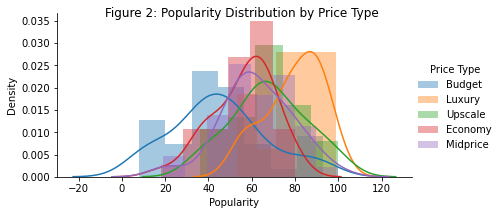

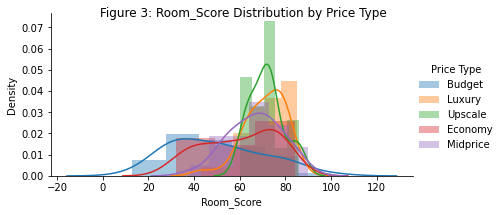

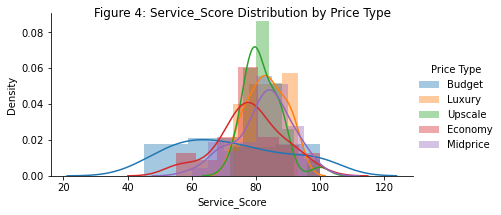

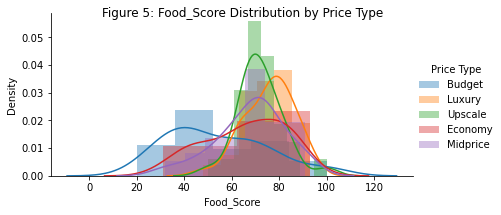

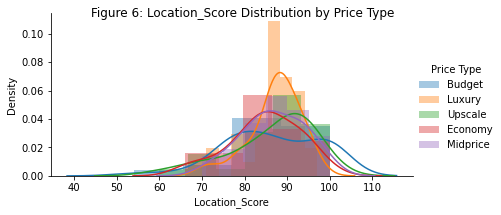

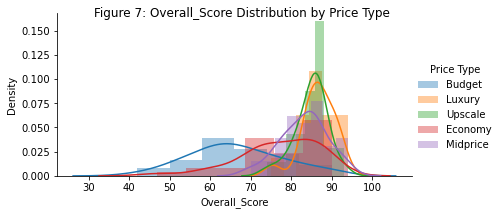

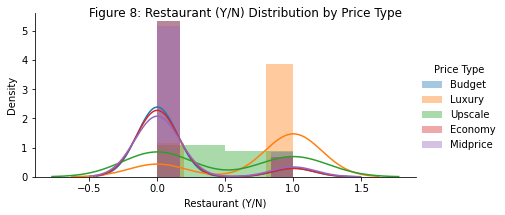

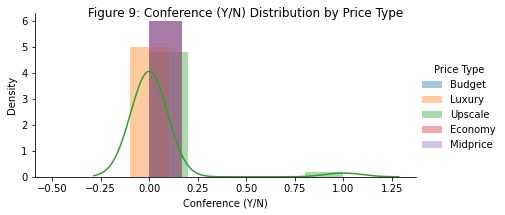

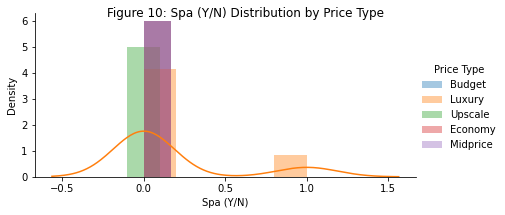

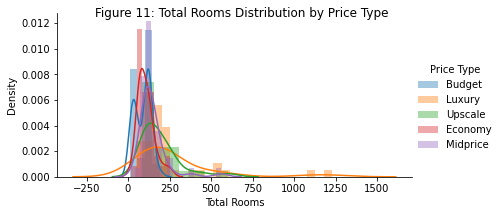

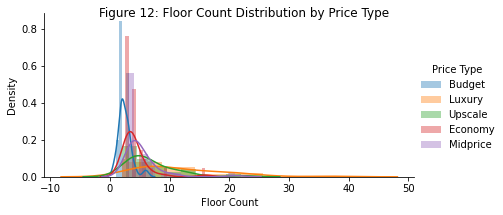

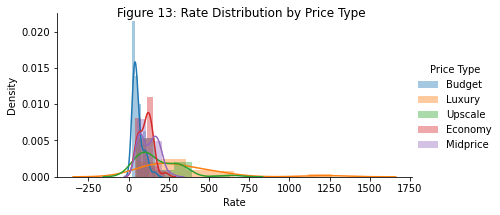

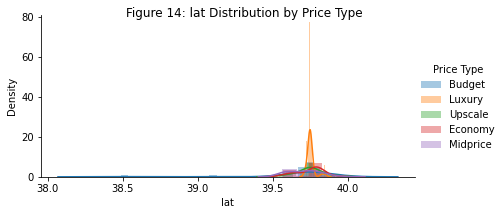

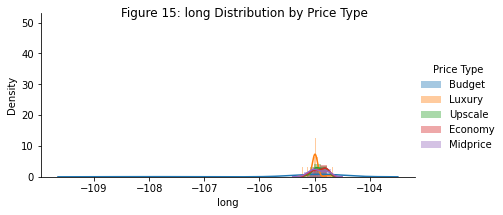

In [69]:
plt.rcParams['figure.max_open_warning']=40
colnames=list(matchedf.select_dtypes(exclude='O').columns.values)
for i in colnames[1:]:
    facet = sns.FacetGrid(matchedf,hue='Price Type',aspect=2)
    facet.map(sns.distplot,i)
    facet.add_legend()
    facet.fig.suptitle(''.join(map(str, list(["Figure ",colnames.index(i)+1,": ",i," Distribution by Price Type"]))))
    plt.show()

### Here is the distribution of the categorial data

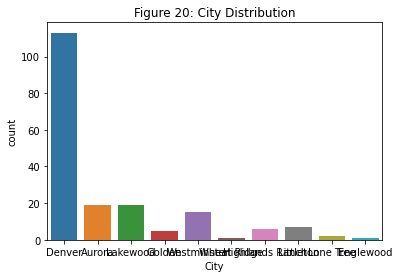

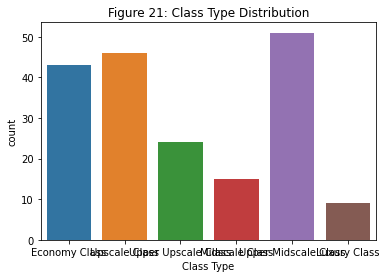

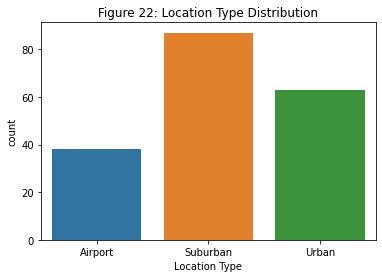

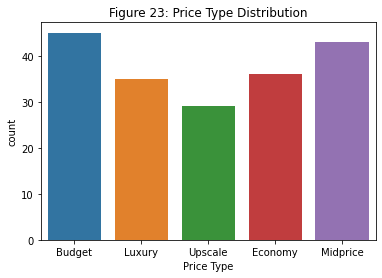

In [70]:
plt.rcParams['figure.max_open_warning']=40
colnames=list(matchedf.select_dtypes(include='O').columns.values[2:])
for i in colnames[0:]:
    ax = plt.axes()
    sns.countplot(x=i, data=matchedf, ax = ax)
    ax.set_title(''.join(map(str, list(["Figure ",colnames.index(i)+20,": ",i," Distribution"]))))
    plt.show()

In [71]:
plt.rcParams['figure.figsize'] = [7, 7]
sns.set_style(style='white')

### plotting with longitude and latitude, the categorial distributions could also be plotted by geolocation data

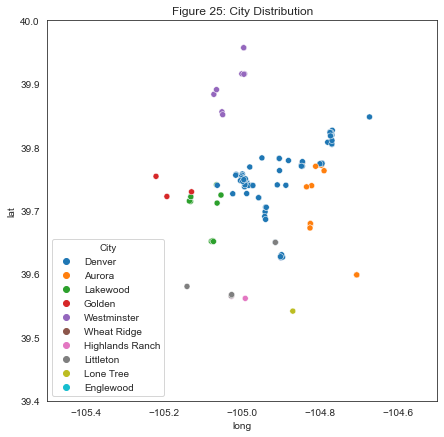

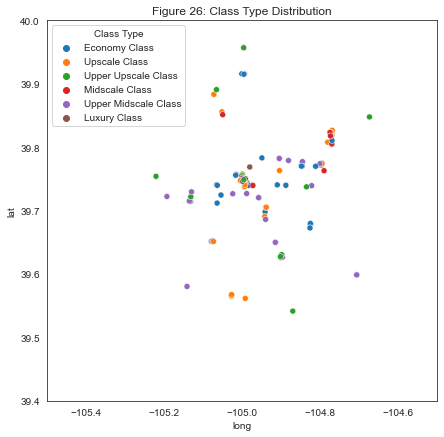

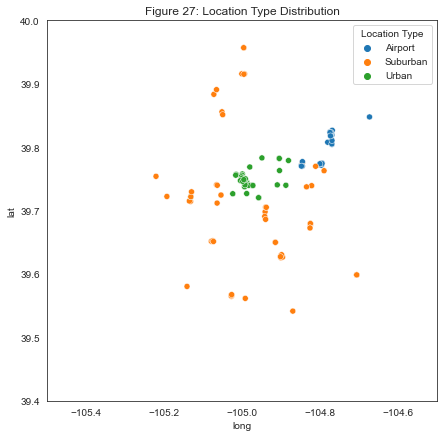

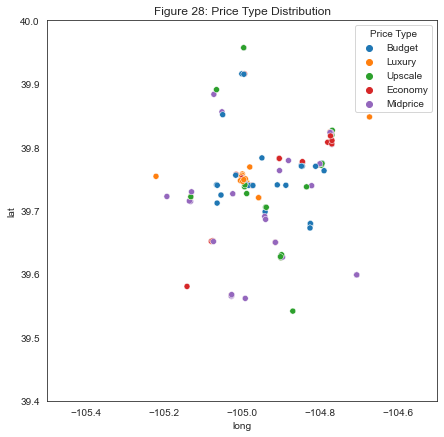

In [72]:
for i in matchedf.select_dtypes(include='O').columns.values[2:]:
    plt.xlim(-105.5, -104.5)
    plt.ylim(39.4, 40)
    sns.scatterplot(matchedf['long'], matchedf['lat'], hue=matchedf[i], ec=None).set(title=''.join(map(str, list(["Figure ",colnames.index(i)+25,": ",i," Distribution"]))))
    plt.show();

### Plotting the heatmap of the of the full numerical dataset, the lighter colors are where the certain columns are more correlated with one another than the darker colors

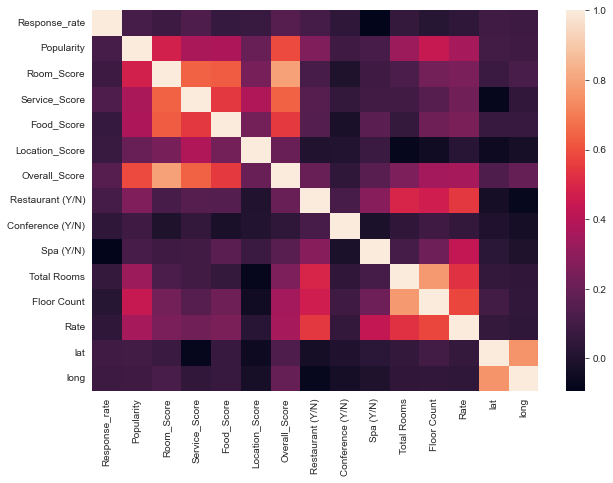

In [73]:
corr = matchedf.corr()
plt.figure(figsize = (10,7))
sns.heatmap(corr,xticklabels=corr.columns.values, yticklabels=corr.columns.values)
plt.show()

### To answer the specific questions: I did pearson's correlation but making a model via random forest regression could be a better way to evaluate the relationships between the dataset with a whole model for feature importance instead of comparing them one at a time

### 1) Overall score is more correlated with room score, service score, popularity, food score and rate, with location score as the 8th feature and is not as correlated as the other 5 scores.

### 2) Location score is more correlated with service score, room score, food score, and then overall score

### 3) Popularity is more correlated with overall score, room score, floor count, food score, service score, and then the price

### 4) Rate is more correlated with floor count, having a restaurant, total rooms, having a spa, overall score, and then popularity

In [74]:
for i in ['Overall_Score','Location_Score','Popularity','Rate']:
    print("Correlation with " + i)
    display(matchedf.corrwith(matchedf[i]).sort_values(ascending=False)[1:])

Correlation with Overall_Score


Room_Score          0.793330
Service_Score       0.640293
Popularity          0.586968
Food_Score          0.549747
Rate                0.355964
Floor Count         0.352987
Total Rooms         0.255174
Location_Score      0.198836
Restaurant (Y/N)    0.198791
long                0.195423
Spa (Y/N)           0.158458
Response_rate       0.153046
lat                 0.131073
Conference (Y/N)    0.040451
dtype: float64

Correlation with Location_Score


Service_Score       0.380657
Room_Score          0.238599
Food_Score          0.230935
Overall_Score       0.198836
Popularity          0.197328
Spa (Y/N)           0.076409
Response_rate       0.069422
Rate                0.025056
Conference (Y/N)    0.005658
Restaurant (Y/N)    0.002612
long               -0.028554
Floor Count        -0.045922
lat                -0.057771
Total Rooms        -0.077430
dtype: float64

Correlation with Popularity


Overall_Score       0.586968
Room_Score          0.477227
Floor Count         0.442533
Food_Score          0.373188
Service_Score       0.363957
Rate                0.355855
Total Rooms         0.329854
Restaurant (Y/N)    0.256849
Location_Score      0.197328
Spa (Y/N)           0.113306
Response_rate       0.110745
lat                 0.099078
long                0.088758
Conference (Y/N)    0.088185
dtype: float64

Correlation with Rate


Floor Count         0.580296
Restaurant (Y/N)    0.543319
Total Rooms         0.530111
Spa (Y/N)           0.430450
Overall_Score       0.355964
Popularity          0.355855
Food_Score          0.251601
Room_Score          0.245626
Service_Score       0.221403
lat                 0.056804
Conference (Y/N)    0.052997
Response_rate       0.041477
long                0.041059
Location_Score      0.025056
dtype: float64

### longitude and latitude are removed because not all columns are complete with that data. hotel name and brand name are too specific to make any generalized categorical dummy variables and are removed, the imputed dummy variables are added to tell the model to consider the imputed variables as separate when modeling the data. A checkpoint is created to revert back to this dataset for the following exercises

In [75]:
matchedf = matchedf.fillna(0).drop(columns = ['Hotel Name_x','long','lat','Brand Name'])
matchedf = pd.concat([matchedf, imputed], axis=1, join="inner")
df = matchedf.copy()

### for the categorical columns, dummy variables are mode

In [76]:
colnames=list(df.select_dtypes(include='O').columns.values)
for i in colnames[0:]:
    # Fill missing data with the word "Missing"
    df[i].fillna("Missing", inplace=True)
    # Create array of dummies
    dummies = pd.get_dummies(df[i], prefix=i)
    # Update X to include dummies and drop the main variable
    df = pd.concat([df, dummies], axis=1)
    df.drop([i], axis=1, inplace=True)

### to have comparable feature selection, minmaxscalar is used to normalize the dataset on a 0 to 1 scale, and kfold is used to stratify the dataset in the training process to reduce overfitting

In [77]:
columns = df.columns
sc = MinMaxScaler(feature_range=(0, 1))
df = sc.fit_transform(df)
df = pd.DataFrame(df, columns=columns)

#x_train, x_test, y_train, y_test = train_test_split(df, y_int, test_size=0.33, random_state=2, stratify=y_int)
kf = KFold(n_splits = 3, shuffle = True, random_state = 2)

### Using overall score as the target variable, use random forest regressor with the regression metrics to evaluate the model

In [78]:
df0 = df.copy()
y = df0.pop('Overall_Score')

In [79]:
model3 = RandomForestRegressor(random_state=2)

for train_idx, test_idx in kf.split(df0, y):
    model3.fit(df0.loc[train_idx],y.loc[train_idx])
    regression_results(y.loc[test_idx],model3.predict(df0.loc[test_idx]))

explained_variance:  0.7775
mean_squared_log_error:  0.0048
r2:  0.7771
MAE:  0.0706
MSE:  0.0105
RMSE:  0.1025
explained_variance:  0.699
mean_squared_log_error:  0.005
r2:  0.6989
MAE:  0.0759
MSE:  0.0116
RMSE:  0.1076
explained_variance:  0.7442
mean_squared_log_error:  0.0055
r2:  0.742
MAE:  0.0701
MSE:  0.0121
RMSE:  0.1098


### for Overall Score as the target variable, room score and service score stands out as the more important features to predict overall score in the random forest regression model -- under the assumption that most of the dataset fed into calculating overall score

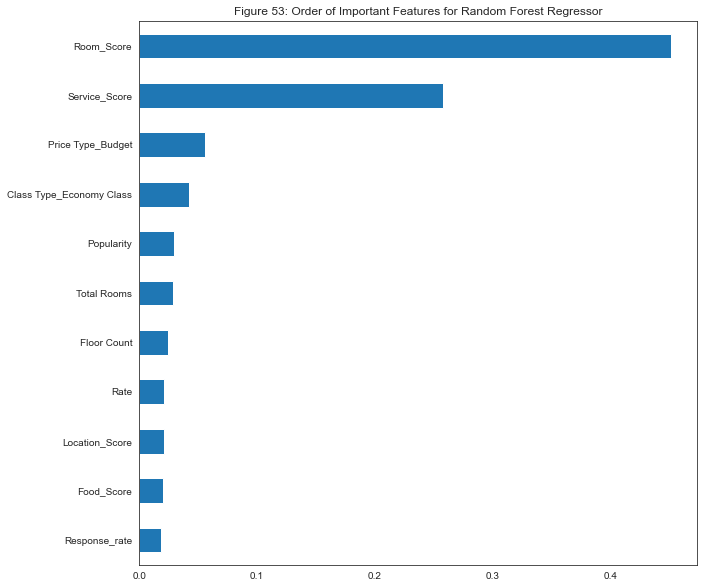

In [80]:
feature_importances = pd.Series(model3.feature_importances_, index=df0.columns)
feature_importances[feature_importances>0.01].sort_values().plot(kind="barh", figsize=(10,10),
                                       title = "Figure 53: Order of Important Features for Random Forest Regressor");

### Using location score as the target variable, use random forest regressor with the regression metrics to evaluate the model -- the rest of the data was not great at predicting location score

In [81]:
df0 = df.copy()
y = df0.pop('Location_Score')

In [82]:
model3 = RandomForestRegressor(random_state=2)

for train_idx, test_idx in kf.split(df0, y):
    model3.fit(df0.loc[train_idx],y.loc[train_idx])
    regression_results(y.loc[test_idx],model3.predict(df0.loc[test_idx]))

explained_variance:  0.2087
mean_squared_log_error:  0.0172
r2:  0.0138
MAE:  0.1511
MSE:  0.0402
RMSE:  0.2006
explained_variance:  -0.1358
mean_squared_log_error:  0.012
r2:  -0.4065
MAE:  0.1297
MSE:  0.034
RMSE:  0.1843
explained_variance:  0.1585
mean_squared_log_error:  0.0128
r2:  0.1529
MAE:  0.134
MSE:  0.0326
RMSE:  0.1805


### for location score as the target variable, service score, food score, and overall score stands out as the more important features to predict location score in the random forest regression model 

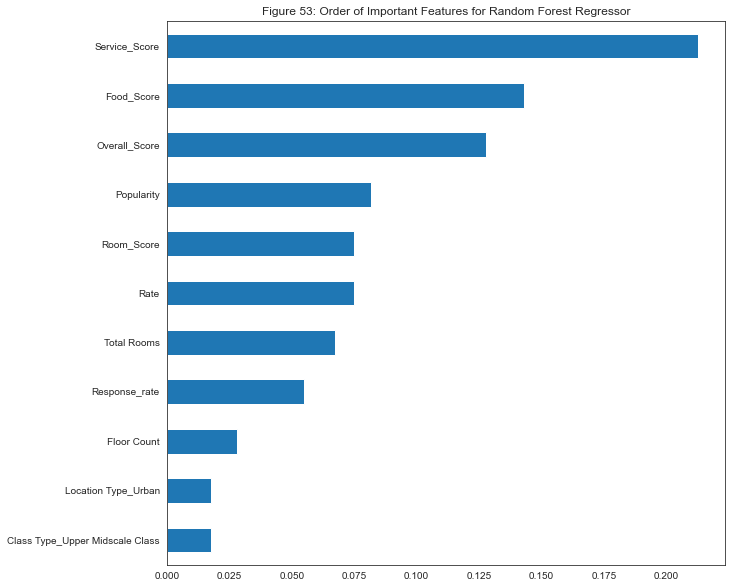

In [83]:
feature_importances = pd.Series(model3.feature_importances_, index=df0.columns)
feature_importances[feature_importances>0.01].sort_values().plot(kind="barh", figsize=(10,10),
                                       title = "Figure 53: Order of Important Features for Random Forest Regressor");

### Using popularity as the target variable, use random forest regressor with the regression metrics to evaluate the model -- the rest of the data was not great at predicting popularity

In [84]:
df0 = df.copy()
y = df0.pop('Popularity')

In [85]:
model3 = RandomForestRegressor(random_state=2)

for train_idx, test_idx in kf.split(df0, y):
    model3.fit(df0.loc[train_idx],y.loc[train_idx])
    regression_results(y.loc[test_idx],model3.predict(df0.loc[test_idx]))

explained_variance:  0.383
mean_squared_log_error:  0.0123
r2:  0.3827
MAE:  0.13
MSE:  0.0284
RMSE:  0.1687
explained_variance:  0.3955
mean_squared_log_error:  0.0169
r2:  0.3728
MAE:  0.1512
MSE:  0.0355
RMSE:  0.1884
explained_variance:  0.5176
mean_squared_log_error:  0.0104
r2:  0.5151
MAE:  0.1196
MSE:  0.0233
RMSE:  0.1525


### for popularity as the target variable, overall score, then total rooms, and food score stands out as the more important features to predict popularity in the random forest regression model 

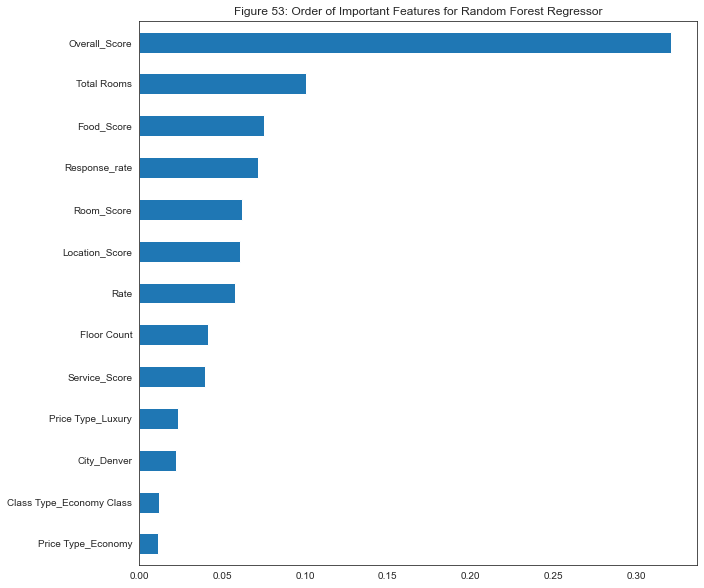

In [86]:
feature_importances = pd.Series(model3.feature_importances_, index=df0.columns)
feature_importances[feature_importances>0.01].sort_values().plot(kind="barh", figsize=(10,10),
                                       title = "Figure 53: Order of Important Features for Random Forest Regressor");

### Using rate as the target variable, use random forest regressor with the regression metrics to evaluate the model -- the rest of the data was decent at predicting rate

In [87]:
df0 = df.copy()
y = df0.pop('Rate')

In [88]:
model3 = RandomForestRegressor(random_state=2)

for train_idx, test_idx in kf.split(df0, y):
    model3.fit(df0.loc[train_idx],y.loc[train_idx])
    regression_results(y.loc[test_idx],model3.predict(df0.loc[test_idx]))

explained_variance:  0.5734
mean_squared_log_error:  0.0024
r2:  0.5576
MAE:  0.0355
MSE:  0.0032
RMSE:  0.0568
explained_variance:  0.4989
mean_squared_log_error:  0.0054
r2:  0.4945
MAE:  0.054
MSE:  0.0113
RMSE:  0.1064
explained_variance:  0.3034
mean_squared_log_error:  0.007
r2:  0.2989
MAE:  0.0624
MSE:  0.0136
RMSE:  0.1167


### for rate as the target variable, having a spa,  total rooms, and luxury class stands out as the more important features to predict rate in the random forest regression model 

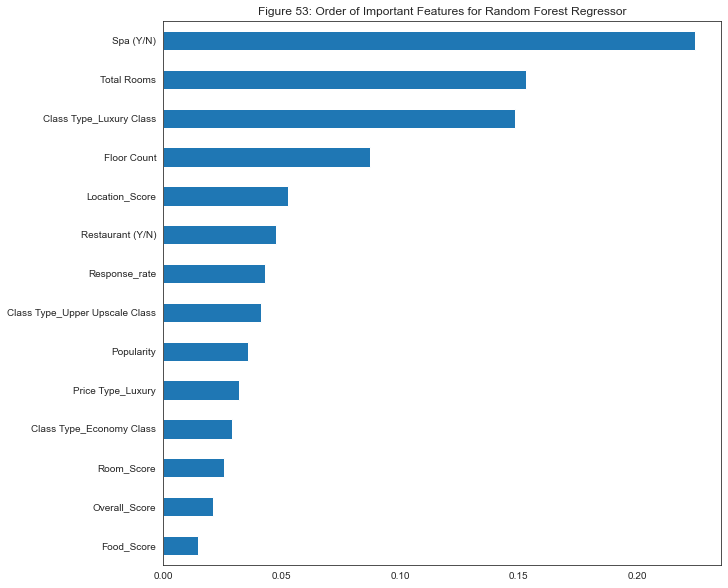

In [89]:
feature_importances = pd.Series(model3.feature_importances_, index=df0.columns)
feature_importances[feature_importances>0.01].sort_values().plot(kind="barh", figsize=(10,10),
                                       title = "Figure 53: Order of Important Features for Random Forest Regressor");

### Using class type as the target variable, use random forest classifier with the classification metrics to evaluate the model -- under the assumption that class type is dependent on price type and rate, this would be an interesting target variable

In [90]:
df = matchedf.copy()
y = df.pop('Class Type')

In [91]:
colnames.remove('Class Type')

### Recreate the dummy variables and scale the data now that class type is removed

In [92]:
for i in colnames[0:]:
    # Fill missing data with the word "Missing"
    df[i].fillna("Missing", inplace=True)
    # Create array of dummies
    dummies = pd.get_dummies(df[i], prefix=i)
    # Update X to include dummies and drop the main variable
    df = pd.concat([df, dummies], axis=1)
    df.drop([i], axis=1, inplace=True)

In [93]:
columns = df.columns
sc = MinMaxScaler(feature_range=(0, 1))
df = sc.fit_transform(df)
df = pd.DataFrame(df, columns=columns)

#x_train, x_test, y_train, y_test = train_test_split(df, y_int, test_size=0.33, random_state=2, stratify=y_int)
kf = KFold(n_splits = 3, shuffle = True, random_state = 2)

### Decision tree classifier model with multiclass metrics

In [94]:
model2 = DecisionTreeClassifier()

for train_idx, test_idx in kf.split(df, y):
    y_score = model2.fit(df.loc[train_idx],y.loc[train_idx])
    print(classification_report(y.loc[test_idx],model2.predict(df.loc[test_idx])))

                      precision    recall  f1-score   support

       Economy Class       1.00      0.89      0.94        18
        Luxury Class       1.00      0.50      0.67         2
      Midscale Class       0.25      0.20      0.22         5
Upper Midscale Class       0.50      0.76      0.60        17
 Upper Upscale Class       0.50      0.60      0.55         5
       Upscale Class       0.60      0.38      0.46        16

            accuracy                           0.63        63
           macro avg       0.64      0.55      0.57        63
        weighted avg       0.66      0.63      0.63        63

                      precision    recall  f1-score   support

       Economy Class       1.00      1.00      1.00        12
        Luxury Class       0.33      0.33      0.33         3
      Midscale Class       0.50      1.00      0.67         4
Upper Midscale Class       0.59      0.50      0.54        20
 Upper Upscale Class       0.60      0.33      0.43         9
    

### random forest classifier with multiclass metrics

In [95]:
model3 = RandomForestClassifier(random_state=2, n_jobs=-1)

for train_idx, test_idx in kf.split(df, y):
    model3.fit(df.loc[train_idx],y.loc[train_idx])
    print(classification_report(y.loc[test_idx],model3.predict(df.loc[test_idx])))

                      precision    recall  f1-score   support

       Economy Class       0.84      0.89      0.86        18
        Luxury Class       0.33      0.50      0.40         2
      Midscale Class       1.00      0.20      0.33         5
Upper Midscale Class       0.58      0.82      0.68        17
 Upper Upscale Class       0.57      0.80      0.67         5
       Upscale Class       0.67      0.38      0.48        16

            accuracy                           0.67        63
           macro avg       0.67      0.60      0.57        63
        weighted avg       0.70      0.67      0.65        63

                      precision    recall  f1-score   support

       Economy Class       0.80      1.00      0.89        12
        Luxury Class       1.00      0.33      0.50         3
      Midscale Class       0.00      0.00      0.00         4
Upper Midscale Class       0.57      0.65      0.60        20
 Upper Upscale Class       0.75      0.67      0.71         9
    

### For predicting multiclass Class Type as the target variable, the rate, total rooms, price type, floor count, and overall score contributes towards predicting Class Type

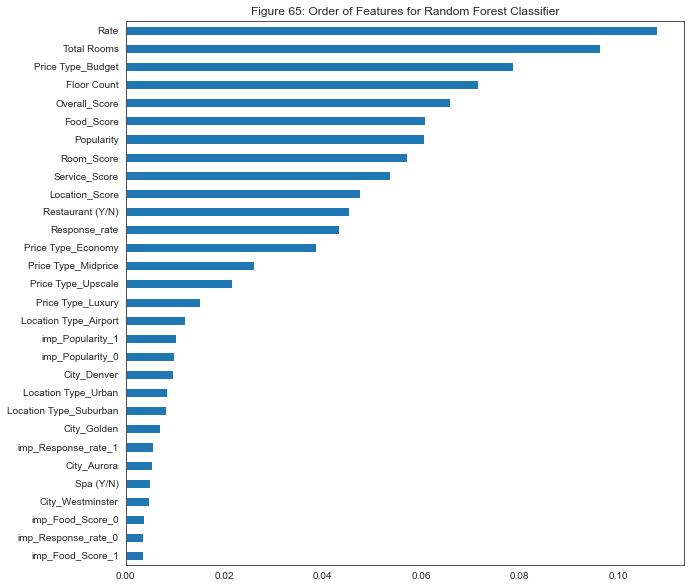

In [96]:
feature_importances = pd.Series(model3.feature_importances_, index=df.columns)
feature_importances.sort_values()[-30:].plot(kind="barh", figsize=(10,10),
                                       title = "Figure 65: Order of Features for Random Forest Classifier");

### Tune the hyperparameters with gridsearch for this multiclass model and rerun the model with its best hyperparameters

In [97]:
hyperparameters = {'max_features': ['auto', 'sqrt', 'log2'],
                   'min_samples_split': [2,3,4]                   
                  }
rfc = RandomForestClassifier(criterion='entropy', n_jobs=-1, random_state=2, n_estimators=100)

search = GridSearchCV(rfc, hyperparameters, cv=3, scoring='accuracy',
                               verbose=3)

search.fit(df.loc[train_idx],y.loc[train_idx])

print(search.best_estimator_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END max_features=auto, min_samples_split=2;, score=0.643 total time=   7.5s
[CV 2/3] END max_features=auto, min_samples_split=2;, score=0.667 total time=   0.1s
[CV 3/3] END max_features=auto, min_samples_split=2;, score=0.619 total time=   0.1s
[CV 1/3] END max_features=auto, min_samples_split=3;, score=0.595 total time=   0.2s
[CV 2/3] END max_features=auto, min_samples_split=3;, score=0.619 total time=   0.2s
[CV 3/3] END max_features=auto, min_samples_split=3;, score=0.690 total time=   0.1s
[CV 1/3] END max_features=auto, min_samples_split=4;, score=0.619 total time=   0.1s
[CV 2/3] END max_features=auto, min_samples_split=4;, score=0.595 total time=   0.1s
[CV 3/3] END max_features=auto, min_samples_split=4;, score=0.714 total time=   0.1s
[CV 1/3] END max_features=sqrt, min_samples_split=2;, score=0.643 total time=   0.1s
[CV 2/3] END max_features=sqrt, min_samples_split=2;, score=0.667 total time=   0.2s
[CV 3

In [98]:
rfc = search.best_estimator_

for train_idx, test_idx in kf.split(df, y):
    rfc.fit(df.loc[train_idx],y.loc[train_idx])
    print(classification_report(y.loc[test_idx],rfc.predict(df.loc[test_idx])))

                      precision    recall  f1-score   support

       Economy Class       0.90      1.00      0.95        18
        Luxury Class       0.50      0.50      0.50         2
      Midscale Class       0.00      0.00      0.00         5
Upper Midscale Class       0.54      0.88      0.67        17
 Upper Upscale Class       0.67      0.80      0.73         5
       Upscale Class       0.71      0.31      0.43        16

            accuracy                           0.68        63
           macro avg       0.55      0.58      0.55        63
        weighted avg       0.65      0.68      0.63        63

                      precision    recall  f1-score   support

       Economy Class       0.80      1.00      0.89        12
        Luxury Class       0.50      0.33      0.40         3
      Midscale Class       0.00      0.00      0.00         4
Upper Midscale Class       0.59      0.65      0.62        20
 Upper Upscale Class       0.83      0.56      0.67         9
    

### Create a visual confusion matrix of the predicted model vs the actual label for the multiclass class type

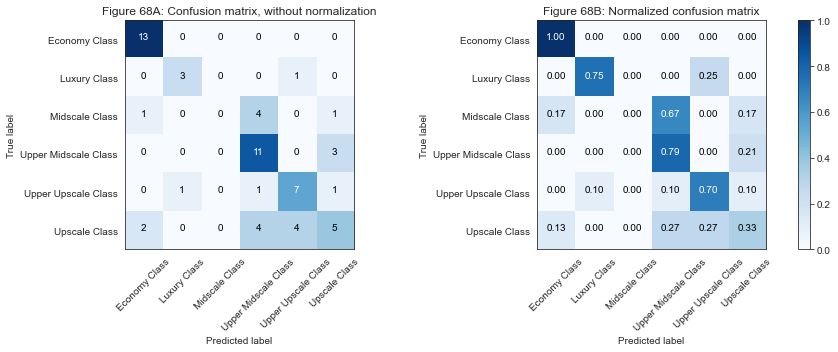

In [99]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y.loc[test_idx],rfc.predict(df.loc[test_idx]))
np.set_printoptions(precision=2)

class_names = ['Economy Class','Luxury Class','Midscale Class','Upper Midscale Class','Upper Upscale Class','Upscale Class']

# Plot non-normalized confusion matrix
plt.figure(figsize = (15,5))
plt.subplot(1, 2, 1)
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Figure 68A: Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.subplot(1, 2, 2)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Figure 68B: Normalized confusion matrix')

plt.tight_layout()
plt.show()

### Overall the model did pretty well for predicting the multiclass classification. The model may have done better had there been more rows to train, cross validate and test the model as future data exploration

### Given that class type of the hotel is may be an arbitrary ranking, perhaps the predictions of those rankings generated by the model may be more suitable for reclassifying the hotel class type and overall score. Perhaps this imperfect information could lead to certain hotels being underrated or overrated for their price point and certain deals could be brokered towards giving discounts for their current price points

### The geolocation way of visualizing the data could be useful for cross comparing hotels for which agglomerative clustering of datasets would prove benefitial to figure out similar hotels labeled or semisupervized in clustering techniques